In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch._six import inf
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch.optim.lr_scheduler import MultiStepLR
from torch import logsumexp
import sys
import time
import datetime

In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 128
STEPS = 10
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS_GLOBAL = D + K
NUM_OBS_LOCAL = D + K*D + K*D
BATCH_SIZE = 100
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
CUDA = False
PATH = 'ag-last-NG-KL-%dsteps' % STEPS

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs_true = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
sigma2_true = torch.from_numpy(np.load('gmm_dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Xs.shape[0]

In [4]:
class Encoder_global(nn.Module):
    def __init__(self, num_obs=NUM_OBS_GLOBAL,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
        self.enc_hidden2 = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.mus_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        hidden = self.enc_hidden(stats)
        q_alpha = torch.exp(self.sigmas_log_alpha(hidden)).view(-1, K, D) ## B * K * D
        q_beta = torch.exp(self.sigmas_log_beta(hidden)).view(-1, K, D) ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample((num_samples,)) ## S * B * K * D
        
        hidden2 = self.enc_hidden2(stats)                 
        q_mean = self.mus_mean(hidden2).view(-1, K, D).unsqueeze(0).repeat(num_samples, 1, 1, 1)
        q_nu = torch.exp(self.mus_log_nu(hidden2).view(-1, K, D))
        q_sigma = torch.sqrt(1. / (q_nu.unsqueeze(0).repeat(num_samples, 1, 1, 1) * precisions))
        mus = Normal(q_mean, q_sigma).sample()  
        return q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions ## mus_mean and mus_sigma are S * B * K * D
    
class Encoder_local(nn.Module):
    def __init__(self, num_obs=NUM_OBS_LOCAL,
                       num_hidden=NUM_HIDDEN,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.enc_onehot = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_latents),
            nn.Softmax(-1))
        
    def forward(self, obs, N, K, D, num_samples, batch_size):
        zs_pi = self.enc_onehot(obs).view(batch_size, N, K)
        zs = cat(zs_pi).sample((num_samples,))
        log_qz = cat(zs_pi).log_prob(zs).view(num_samples, batch_size, -1).sum(-1) ## S * B
        zs = zs.view(num_samples, batch_size, -1, K) ## S * B * N * K
        return zs_pi, zs, log_qz

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)     
        
def initialize():
    enc_global = Encoder_global()
    enc_local = Encoder_local()
    enc_global.apply(weights_init)

    optimizer =  torch.optim.Adam(list(enc_global.parameters()) + list(enc_local.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_global, enc_local, optimizer
enc_global, enc_local, optimizer = initialize()

In [6]:
prior_mean = torch.zeros((BATCH_SIZE, K, D))
prior_nu = torch.ones((BATCH_SIZE, K, D))
prior_alpha = torch.ones((BATCH_SIZE, K, D)) * 2.0
prior_beta = torch.ones((BATCH_SIZE, K, D)) * 2.0

def log_joints_gmm(X, Z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
    log_probs = torch.zeros(batch_size).float()
    ## priors on mus and sigmas size B
    log_probs = log_probs + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
    log_probs = log_probs + Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    sigmas = 1. / torch.sqrt(precisions)
    log_probs = log_probs + Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), 
                                   sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(X).sum(-1).sum(-1)
    return log_probs

def inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
    precisions = Gamma(prior_alpha, prior_beta).sample()
    prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
    mus = Normal(prior_mean, prior_sigma).sample()
    ## log prior size B
    log_p =  Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1) + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    return mus, precisions, log_p

def E_step(X, mus, precisions, N, D, K, batch_size):
    mus_flat = mus.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    sigma = 1. / torch.sqrt(precisions)
    sigma_flat = sigma.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    data = torch.cat((X, mus_flat, sigma_flat), -1).view(batch_size*N, -1)
    zs_pi, zs, log_q_z = enc_local(data, N, K, D, 1, batch_size)
    return zs_pi, zs[0], log_q_z[0]

def M_step(X, z, N, D, K, batch_size):
    data = torch.cat((X, z), dim=-1).view(batch_size*N, -1)
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc_global(data, K, D, 1, batch_size)  
    log_q_eta =  Normal(q_mean[0], q_sigma[0]).log_prob(mus[0]).sum(-1).sum(-1) + Gamma(q_alpha, q_beta).log_prob(precisions[0]).sum(-1).sum(-1)## B
    return q_mean[0], q_nu, q_alpha, q_beta, q_sigma[0], mus[0], precisions[0], log_q_eta

def post_global(Xs, Zs, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size):
    stat1 = Zs.sum(1).unsqueeze(-1).repeat(1, 1, D) ## B * K * D
    xz_nk = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)) # B*N*K*D
    stat2 = xz_nk.sum(1) ## B*K*D
    stat3 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), torch.mul(Xs, Xs).unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    stat1_nonzero = stat1
    stat1_nonzero[stat1_nonzero == 0.0] = 1.0
    x_bar = stat2 / stat1
    posterior_beta = prior_beta + (stat3 - (stat2 ** 2) / stat1_nonzero) / 2. + (stat1 * prior_nu / (stat1 + prior_nu)) * ((prior_nu**2) + x_bar**2 - 2 * x_bar *  prior_nu) / 2.
    posterior_nu = prior_nu + stat1
    posterior_mean = (prior_mean * prior_nu + stat2) / (prior_nu + stat1) 
    posterior_alpha = prior_alpha + (stat1 / 2.)
#     posterior_sigma = torch.sqrt(posterior_nu * (posterior_beta / posterior_alpha))
    return posterior_mean, posterior_nu, posterior_alpha, posterior_beta

def post_local(Xs, Pi, mus, precisions, N, K, D, batch_size):
    sigma = 1. / torch.sqrt(precisions)
    mus_expand = mus.unsqueeze(2).repeat(1, 1, N, 1)
    sigma_expand = sigma.unsqueeze(2).repeat(1, 1, N, 1)
    Xs_expand = Xs.unsqueeze(1).repeat(1, K, 1, 1)
    log_gammas = Normal(mus_expand, sigma_expand).log_prob(Xs_expand).sum(-1).transpose(-1, -2) # B * N * K
    log_pis = log_gammas - logsumexp(log_gammas, dim=-1).unsqueeze(-1)
    return log_pis
    


def ag(x, Pi, z_true, mus_true, sigma2_true, N, K, D, num_samples, steps, batch_size):
    """
    train both encoders
    rws gradient estimator
    sis sampling scheme
    no resampling
    """
    kls_eta_ex = torch.zeros((num_samples, batch_size))
    kls_eta_in = torch.zeros((num_samples, batch_size))
    kls_z_ex = torch.zeros((num_samples, batch_size))
    kls_z_in = torch.zeros((num_samples, batch_size))
    ##
    log_increment_weights = torch.zeros((steps, num_samples, batch_size))
    Z_samples = torch.zeros((num_samples, batch_size, N, K))
    for m in range(steps):
        if m == 0:
            for l in range(num_samples):
                mus, precisions, log_p_eta = inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                labels = z.nonzero()
                log_p_z = cat(Pi).log_prob(z).sum(-1)
                sigmas = 1. / torch.sqrt(precisions)
                log_p_x = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1)
                log_increment_weights[m, l] = log_p_x + log_p_z - log_q_z     
        else:
            for l in range(num_samples):
                z_prev = Z_samples[l]
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z_prev, N, D, K, batch_size)
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                log_p_joint = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                log_increment_weights[m, l] = log_p_joint - log_q_z - log_q_eta
                if m == (steps-1):
                    ## kl of global
                    p_mean, p_nu, p_alpha, p_beta = post_global(x, z, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size)
                    kl_eta_ex, kl_eta_in = kls_NGs(p_mean, p_nu, p_alpha, p_beta, q_mean, q_nu, q_alpha, q_beta)
                    kls_eta_ex[l] = kl_eta_ex
                    kls_eta_in[l] = kl_eta_in
                    ## kl of local
                    p_logits = post_local(x, Pi, mus, precisions, N, K, D, batch_size)
                    kl_z_ex, kl_z_in = kls_cats(p_logits, torch.log(zs_pi))
                    kls_z_ex[l] = kl_z_ex
                    kls_z_in[l] = kl_z_in    
    log_last_weights = log_increment_weights[-1] ## S * B
    last_weights = torch.exp(log_last_weights - logsumexp(log_last_weights, 0)).detach()
    ess = (1./ (last_weights ** 2).sum(0)).mean()
    ## EUBO and ELBO
    eubo = torch.mul(last_weights, log_last_weights).sum(0).mean()
    elbo = log_last_weights.mean(0).mean()
    ## weighted average KLs for local and global posterior
    final_weights = last_weights
    ##
    KL_eta_ex = torch.mul(final_weights, kls_eta_ex).sum(0).mean()
    KL_eta_in = torch.mul(final_weights, kls_eta_in).sum(0).mean()
    KL_z_ex = torch.mul(final_weights, kls_z_ex).sum(0).mean()
    KL_z_in = torch.mul(final_weights, kls_z_in).sum(0).mean()     
    return eubo, elbo, ess, KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

In [7]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_eta_ex = []
KLs_eta_in = []
KLs_z_ex = []
KLs_z_in = []

num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex = 0.0
    KL_eta_in = 0.0
    KL_z_ex = 0.0
    KL_z_in = 0.0

    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs_true[batch_indices]
        batch_mus = mus_true[batch_indices]
        batch_sigma2 = sigma2_true[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in = ag(batch_Xs, Pi, batch_Zs, batch_mus, batch_sigma2, N, K, D, NUM_SAMPLES, STEPS, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex += kl_eta_ex.item()
        KL_eta_in += kl_eta_in.item()
        KL_z_ex += kl_z_ex.item()
        KL_z_in += kl_z_in.item()
        
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    KL_eta_ex /= num_batches
    KL_eta_in /= num_batches
    KL_z_ex /= num_batches
    KL_z_in /= num_batches

    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    ##
    KLs_eta_ex.append(KL_eta_ex)
    KLs_eta_in.append(KL_eta_in)
    KLs_z_ex.append(KL_z_ex)
    KLs_z_in.append(KL_z_in)

    time_end = time.time()
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
              % (epoch, EUBO, ELBO, ESS,  KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-307.846, ELBO=-587.808, ESS=1.025, EX_eta=410.421, IN_eta=16.275, EX_z=92.630, IN_z=nan (9s)
epoch=10, EUBO=-184.665, ELBO=-203.755, ESS=1.250, EX_eta=40.262, IN_eta=55.490, EX_z=5.730, IN_z=3.682 (90s)
epoch=20, EUBO=-179.083, ELBO=-202.712, ESS=1.247, EX_eta=47.663, IN_eta=78.888, EX_z=3.264, IN_z=2.938 (90s)
epoch=30, EUBO=-178.474, ELBO=-200.265, ESS=1.271, EX_eta=47.737, IN_eta=79.584, EX_z=2.482, IN_z=2.516 (90s)
epoch=40, EUBO=-177.292, ELBO=-204.637, ESS=1.217, EX_eta=55.603, IN_eta=63.097, EX_z=2.504, IN_z=2.623 (89s)
epoch=50, EUBO=-176.989, ELBO=-204.044, ESS=1.217, EX_eta=55.115, IN_eta=66.400, EX_z=2.346, IN_z=2.206 (90s)
epoch=60, EUBO=-177.541, ELBO=-205.873, ESS=1.217, EX_eta=58.128, IN_eta=67.376, EX_z=2.414, IN_z=2.301 (90s)
epoch=70, EUBO=-176.572, ELBO=-202.845, ESS=1.235, EX_eta=55.712, IN_eta=62.679, EX_z=1.873, IN_z=1.984 (90s)
epoch=80, EUBO=-177.324, ELBO=-203.711, ESS=1.237, EX_eta=58.387, IN_eta=65.542, EX_z=2.154, IN_z=2.571 (90s)
epoch=90, EU

KeyboardInterrupt: 

In [8]:
torch.save(enc_global.state_dict(), 'models/global-enc-' + PATH)
torch.save(enc_local.state_dict(), 'models/local-enc' + PATH)

In [9]:
def save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in):
    fout = open('results/logs-' + PATH +'.txt', 'w+')
    fout.write('EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) 
                   + str(KLs_eta_ex[i]) + str(KLs_eta_in[i]) + str(KLs_z_ex[i]) + str(KLs_z_in[i]) + '\n')
    fout.close()
save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in)

In [12]:
def plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, num_samples):
    fig = plt.figure(figsize=(20, 30))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax1.tick_params(labelsize=18)
    ax1.set_ylim([-220, -130])
    ax1.legend(fontsize=18)
    ##
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(KLs_eta_ex, '#66b3ff', label='KLs_eta_ex')
    ax2.plot(KLs_eta_in, '#ff9999', label='KLs_eta_in')
    ax2.plot(KLs_z_ex, '#99ff99', label='KLs_z_ex')
    ax2.plot(KLs_z_in, 'gold', label='KLs_z_in')   
    ax2.plot(np.ones(len(KLs_z_in)) * 5, 'k', label='const=5.0')
    ax2.legend(fontsize=18)
    ax2.tick_params(labelsize=18)
    ax2.set_ylim([-1, 30])
    ##
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel('epochs (%d gradient steps per epoch)'  % num_batches, size=18)
    ax3.legend()
    plt.savefig('results/train-' + PATH + '.svg')

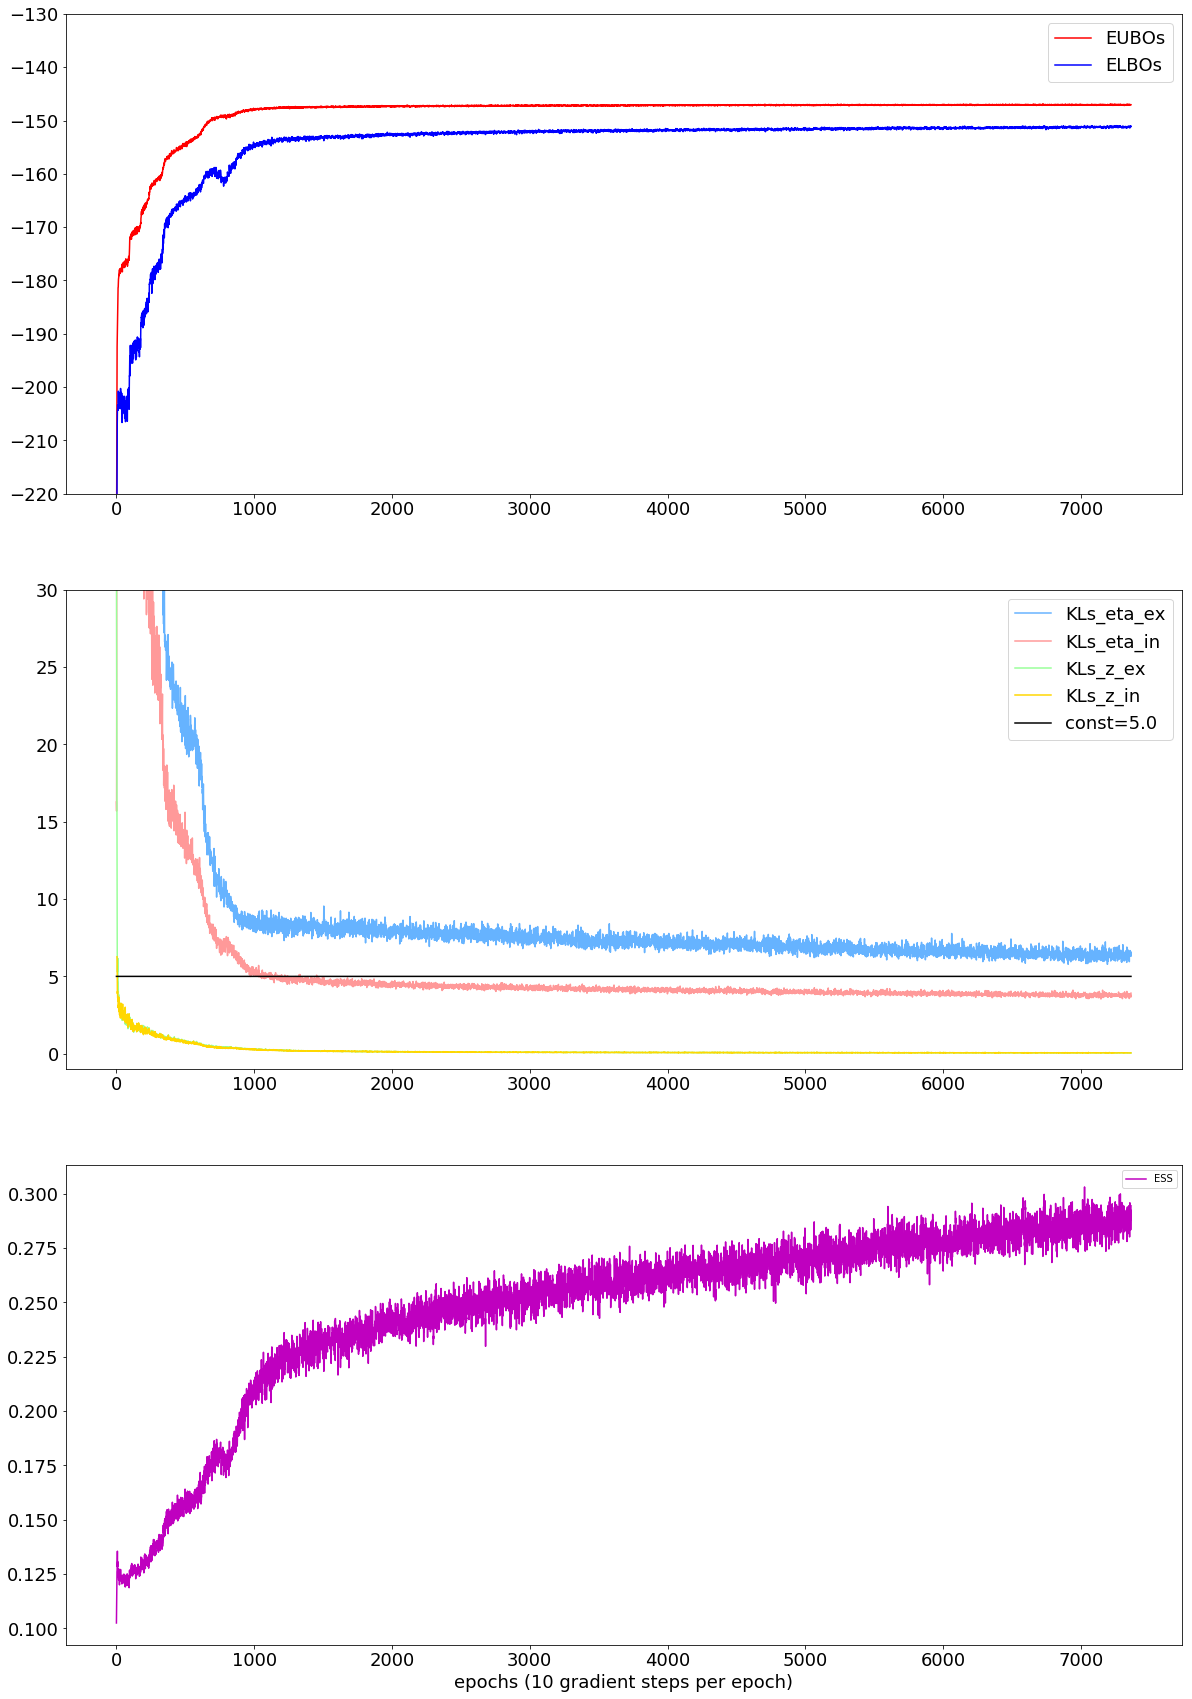

In [13]:
plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, NUM_SAMPLES)

In [14]:
STEPS = 200

def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Zs = Zs_true[batch_indices]
    batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, batch_size)
    return batch_Xs, batch_Zs

def test(x, num_seqs, Pi, N, K, D, steps, batch_size):
    LLs = [] 
    for m in range(steps):
        if m == 0:
            mus, precisions, log_p_eta = inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
        else:
            q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z, N, D, K, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
            labels = z.nonzero()
            sigmas = 1. / torch.sqrt(precisions)
            ll = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1).mean()
            LLs.append(ll.item())
    E_precisions = q_alpha / q_beta
    E_mus = q_mean
    E_z = torch.argmax(zs_pi, dim=-1)

    return z, mus, precisions, LLs, E_mus, E_precisions, E_z

x,z_true = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)
z, mus, precisions, LLs, E_mus, E_precisions, E_z = test(x, num_seqs, Pi, N, K, D, STEPS, BATCH_SIZE)

In [15]:
def plot_final_samples(Xs, Zs, mus, precisions, steps, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,100))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b].data.numpy()
        mu = mus[b].data.numpy()
        precision = precisions[b].data.numpy()

        covs = np.zeros((K, D, D))
        assignments = z
        for k in range(K):
            covs[k] = np.diag(1. / precision[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=covs[k], pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('results/modes' + PATH + '.svg')

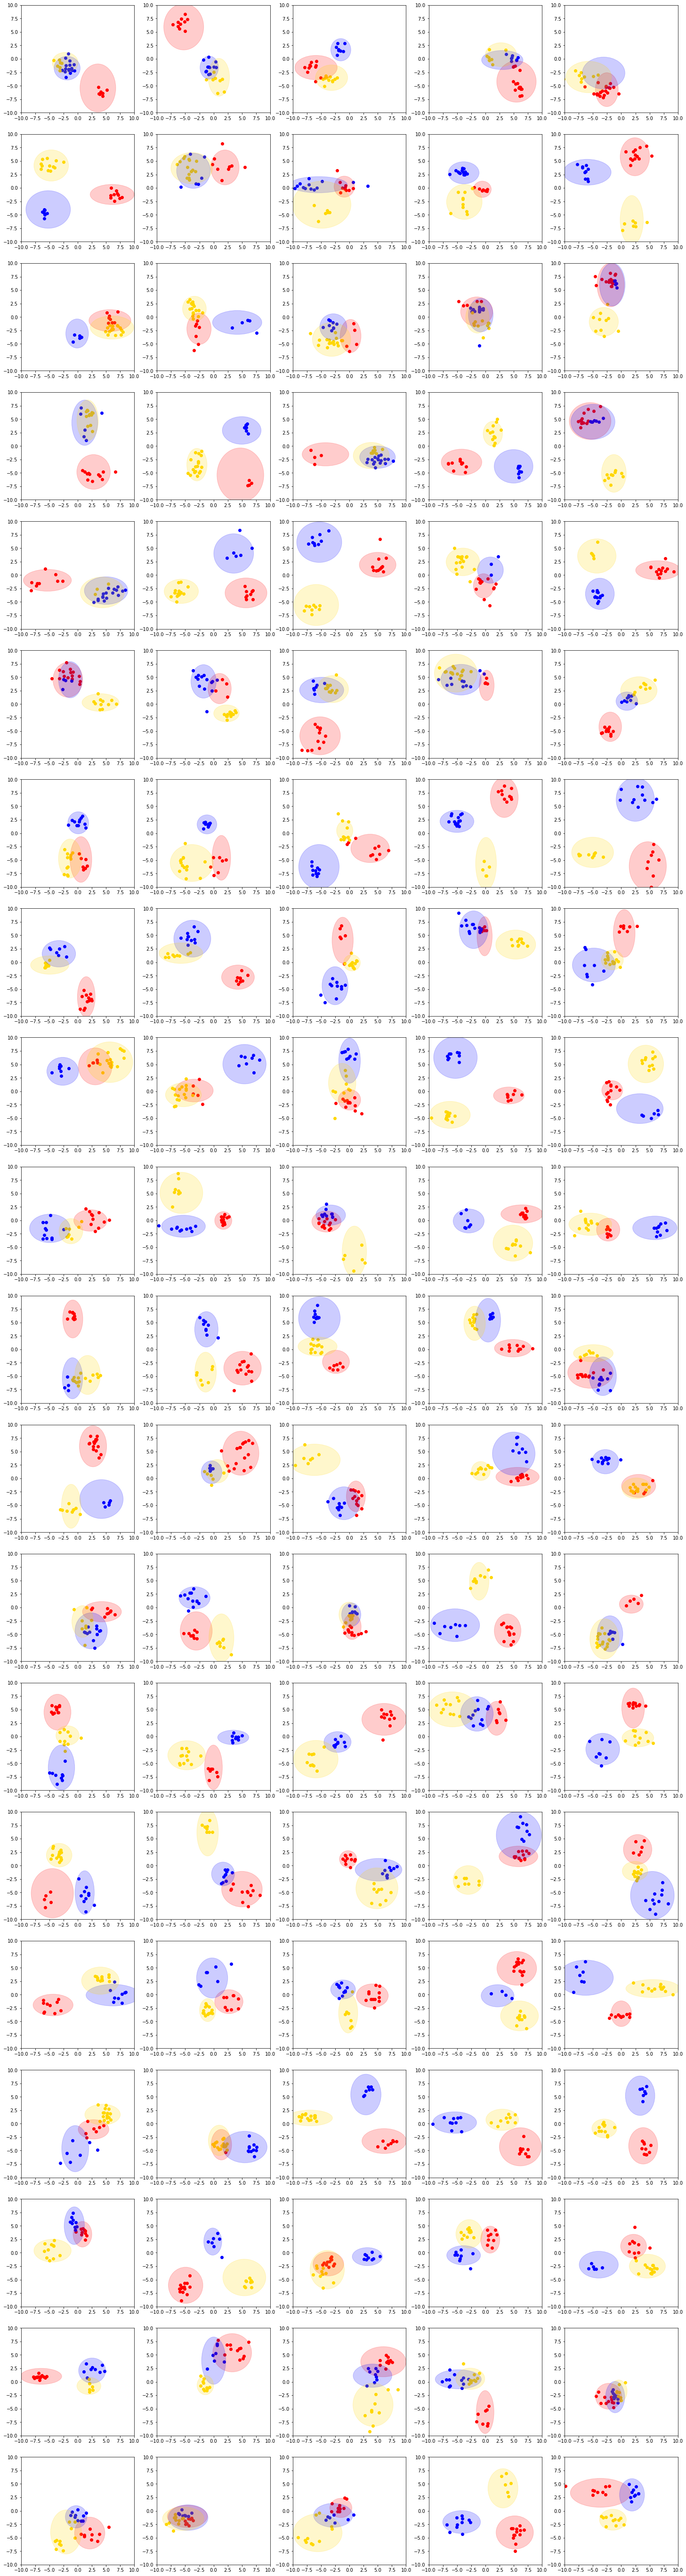

In [16]:
plot_final_samples(x, E_z, E_mus, E_precisions, STEPS, BATCH_SIZE)

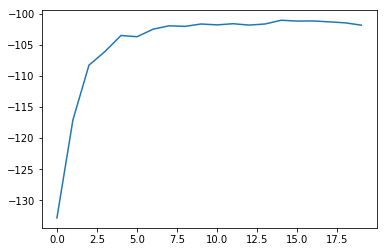

In [20]:
plt.plot(LLs[:20])

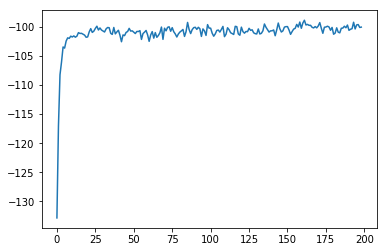

In [19]:
plt.plot(LLs)

In [ ]:
plt.plot(LLs[:10])

In [ ]:
np.array(LLs).mean()

In [ ]:
LLs[20]